### TASK 3

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.metrics import classification_report

# Load the dataset
data = pd.read_csv('dataset.csv')

# Preprocess the data
data['Cuisines'] = data['Cuisines'].str.split(', ')

# Handle missing values in 'Cuisines' column
data['Cuisines'] = data['Cuisines'].apply(lambda x: x if isinstance(x, list) else ['Unknown'])

# Explode the Cuisines column
data = data.explode('Cuisines')

# Remove duplicates
data = data.drop_duplicates(subset=['Restaurant ID', 'Cuisines'])

# Group by 'Restaurant ID' and aggregate cuisines
grouped_cuisines = data.groupby('Restaurant ID')['Cuisines'].apply(list)

# Encode the Cuisines column
mlb = MultiLabelBinarizer()
cuisines_encoded = mlb.fit_transform(grouped_cuisines)

# Prepare the features
features = data[['Restaurant ID', 'City']].drop_duplicates().set_index('Restaurant ID')

# One-hot encode the 'City' column
ohe = OneHotEncoder()
city_encoded = ohe.fit_transform(features[['City']]).toarray()
city_encoded_df = pd.DataFrame(city_encoded, index=features.index, columns=ohe.get_feature_names_out(['City']))

# Join the one-hot encoded city data with the features
features = features.drop(columns=['City']).join(city_encoded_df)

# Join the one-hot encoded cuisines data with the features
features = features.join(pd.DataFrame(cuisines_encoded, index=features.index, columns=mlb.classes_))

# Prepare the target variable
target = pd.DataFrame(cuisines_encoded, index=features.index, columns=mlb.classes_)

# Ensure the features and target have the same index
features, target = features.align(target, join='inner', axis=0)



In [2]:
# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [3]:
# Step 2: Train a RandomForest model
model = RandomForestClassifier()

In [4]:
# Step 3: Use GridSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(model, param_grid, cv=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [5]:
# Step 4: Train the model with the best parameters
best_model = grid_search.best_estimator_

# Step 5: Predict on the test set
y_pred = best_model.predict(X_test)

# Step 6: Ensure y_test is an ndarray if it's not already
if isinstance(y_test, pd.Series):
    y_true = y_test.values
else:
    y_true = y_test

In [6]:
# Step 7: Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Step 8: Feature importance
importance = best_model.feature_importances_
for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v}')

Accuracy: 0.9204604918890633
Feature: 0, Score: 0.00025486113737397607
Feature: 1, Score: 0.0002012191553872537
Feature: 2, Score: 0.00012964564386055082
Feature: 3, Score: 7.219852505427728e-05
Feature: 4, Score: 0.00018388296023596348
Feature: 5, Score: 0.00031158793297764403
Feature: 6, Score: 0.00030023223257370237
Feature: 7, Score: 3.6245792236593136e-06
Feature: 8, Score: 0.0002652548334198493
Feature: 9, Score: 0.00020018235189950251
Feature: 10, Score: 0.00027982193824247577
Feature: 11, Score: 0.00022044430041776958
Feature: 12, Score: 3.175500489598966e-07
Feature: 13, Score: 2.6382115835951697e-05
Feature: 14, Score: 0.00021680493786784723
Feature: 15, Score: 0.0
Feature: 16, Score: 0.00011859279100875292
Feature: 17, Score: 0.0001836731225507123
Feature: 18, Score: 0.00014515233015653407
Feature: 19, Score: 4.878848762421458e-05
Feature: 20, Score: 0.0005400605992431626
Feature: 21, Score: 0.0002581631286720665
Feature: 22, Score: 0.00018366955222126307
Feature: 23, Score:

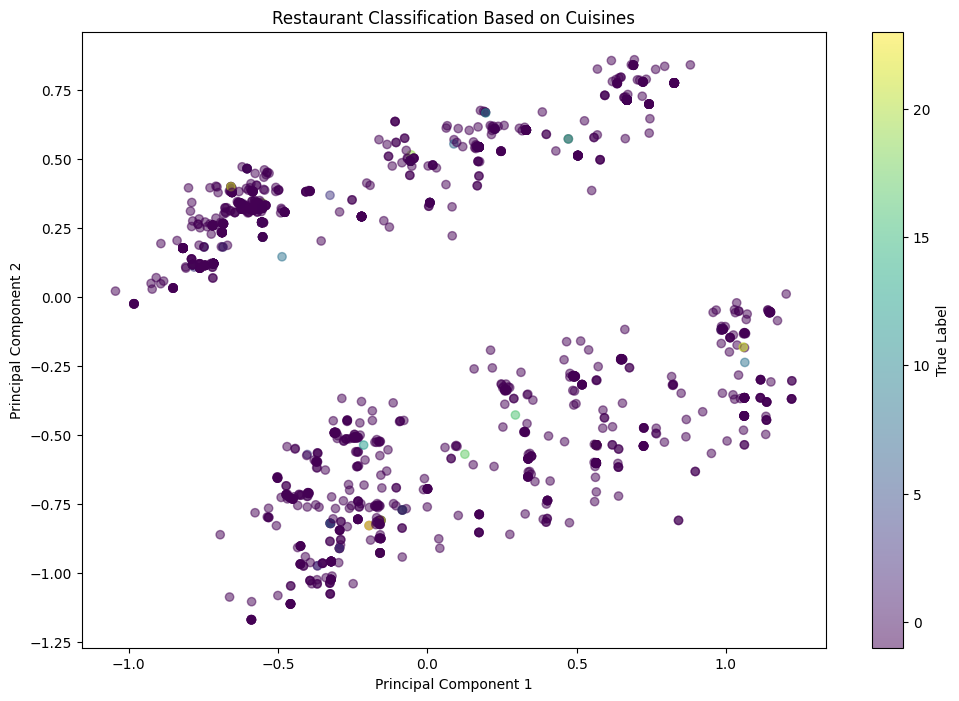

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_reduced = pca.fit_transform(X_test)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(X_test_reduced, columns=['PC1', 'PC2'])
plot_df['True Label'] = y_test.idxmax(axis=1)  # Assuming multi-label, getting the true labels
plot_df['Predicted Label'] = pd.DataFrame(y_pred, index=X_test.index).idxmax(axis=1)

# Plot the results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], c=plot_df['True Label'].astype('category').cat.codes, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Restaurant Classification Based on Cuisines')
plt.colorbar(scatter, label='True Label')
plt.show()